In [210]:
import numpy as np
import pandas as pd
from rdkit.Chem import Descriptors
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import defaultdict
from matplotlib import pyplot as plt
import json
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

plt.style.use('ggplot')

In [61]:
data = pd.read_csv('/Users/zhujiayuan/Desktop/binding_affinity/activity_data.csv')

In [62]:
data.head(5)

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,LUO-POS-e1dab717-11,NaN,NaN,NaN,NaN,NaN,0.275118,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,LUO-POS-e1dab717-12,NaN,NaN,NaN,NaN,NaN,0.202767,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,MAT-POS-e48723dc-1,NaN,NaN,NaN,NaN,NaN,55.453947,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,MAT-POS-e48723dc-2,NaN,NaN,NaN,NaN,NaN,0.050000,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,LUO-POS-9931618f-2,NaN,NaN,NaN,NaN,NaN,0.052757,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN


In [63]:
list(data.columns)

['SMILES',
 'CID',
 'canonical_CID',
 'r_inhibition_at_20_uM',
 'r_inhibition_at_50_uM',
 'r_avg_IC50',
 'f_inhibition_at_20_uM',
 'f_inhibition_at_50_uM',
 'f_avg_IC50',
 'f_avg_pIC50',
 'relative_solubility_at_20_uM',
 'relative_solubility_at_100_uM',
 'trypsin_IC50',
 'NMR_std_ratio',
 'acrylamide',
 'chloroacetamide',
 'series',
 'frag_id']

In [84]:
subdata = data[['SMILES', 'CID', 'f_avg_IC50']]
subdata #(2062,3)

,SMILES,CID,f_avg_IC50
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,0.275118
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,0.202767
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,55.453947
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,0.050000
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,0.052757
...,...,...,...
2057,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,WAR-XCH-eb7b662f-2,99.010000
2058,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,DAR-DIA-23aa0b97-8,54.272964
2059,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,DAR-DIA-23aa0b97-11,63.554925
2060,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,26.719515


### Drop Nan

In [80]:
print(subdata['SMILES'].isnull().values.any())
print(subdata['CID'].isnull().values.any())
print(subdata['f_avg_IC50'].isnull().values.any())

False
False
True


In [81]:
subdata['f_avg_IC50'].isnull().sum()

136

In [82]:
is_NaN = subdata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = subdata[row_has_NaN]
rows_with_NaN

,SMILES,CID,f_avg_IC50
985,O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)c...,ALP-UNI-3496895b-8,NaN
1107,O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)c...,KAD-UNI-8a629cb0-21,NaN
1255,O=C(Nc1cncc2cnccc12)[C@H]1CCOc2ccc(Cl)cc21,ALP-POS-ce760d3f-2,NaN
1324,COc1cc(Cl)cc2c1OCC[C@@H]2C(=O)Nc1cncc2ccccc12,MAT-POS-43fe65f4-1,NaN
1343,COc1ccc2c(N)nn(C(=O)C3CCOc4ccc(Cl)cc43)c2c1,ALP-POS-79636100-2,NaN
...,...,...,...
2025,Cc1ccn2c(-c3ccc4[nH]ncc4c3)c(-c3ccc(F)cc3)nc2c1,ALV-UNI-7ff1a6f9-14,NaN
2029,CC1C(O)CCCN1Cc1ccccc1,MAK-UNK-6435e6c2-9,NaN
2038,O=C(CCl)N1CCN(Cc2cccc(Cl)c2)C[C@@H]1Cc1ccccc1,DAN-LON-a5fc619e-10,NaN
2045,CS(=O)(=O)N(CCc1ccccc1)CC1CCN(C(=O)CCl)CC1,DUN-NEW-f8ce3686-25,NaN


In [85]:
subdata = subdata.dropna()
subdata = subdata.reset_index(drop=True)
subdata #(1926, 3)

,SMILES,CID,f_avg_IC50
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,0.275118
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,0.202767
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,55.453947
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,0.050000
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,0.052757
...,...,...,...
1921,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,WAR-XCH-eb7b662f-2,99.010000
1922,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,DAR-DIA-23aa0b97-8,54.272964
1923,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,DAR-DIA-23aa0b97-11,63.554925
1924,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,26.719515


### Features from descriptors

In [86]:
# Helper function to compute descriptors for a single molecule
def compute_descriptors(molecule):
    descriptors = {d[0]: d[1](molecule) for d in Descriptors.descList}
    return descriptors

In [87]:
ligand_feature = {}
for i in range(len(subdata)):
    smile = subdata.loc[i, 'SMILES']
    mol = Chem.MolFromSmiles(smile)
    ligand_feature[smile] = compute_descriptors(mol)

In [102]:
ligand_feature_df = pd.DataFrame.from_dict(ligand_feature).T
ligand_feature_df.index.name = 'SMILES'
ligand_feature_df = ligand_feature_df.reset_index(level=0)

### Lipinski's rule of five

In [103]:
ligand_feature_df['f_avg_IC50'] = subdata['f_avg_IC50']
ligand_feature_df #(1926, )

,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,f_avg_IC50
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,14.101608,-3.985876,14.101608,0.012679,0.595886,498.992,475.808,498.112854,176.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275118
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,14.199184,-3.990499,14.199184,0.027211,0.552657,525.030,499.830,524.128504,186.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202767
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,14.256036,-0.977480,14.256036,0.097800,0.631099,474.948,451.764,474.145868,172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.453947
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,14.256036,-0.977480,14.256036,0.097800,0.631099,474.948,451.764,474.145868,172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,14.024602,-0.973105,14.024602,0.108876,0.667543,448.910,427.742,448.130218,162.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,11.716797,-0.431337,11.716797,0.378868,0.880716,272.695,263.623,272.046489,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,99.010000
1922,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,11.719064,-0.428250,11.719064,0.428250,0.762446,253.265,242.177,253.096360,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54.272964
1923,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,11.983708,-0.379775,11.983708,0.379775,0.671507,277.287,266.199,277.096360,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,63.554925
1924,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,12.203380,-0.131257,12.203380,0.131257,0.803499,287.322,274.218,287.105862,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.719515


In [104]:
rule_five_df = ligand_feature_df[['NumHDonors', 'NumHAcceptors', 'MolWt', 'MolLogP', 'f_avg_IC50']]
rule_five_df.head()

,NumHDonors,NumHAcceptors,MolWt,MolLogP,f_avg_IC50
0,1.0,5.0,498.992,2.7033,0.275118
1,1.0,5.0,525.030,3.0934,0.202767
2,1.0,4.0,474.948,3.2973,55.453947
3,1.0,4.0,474.948,3.2973,0.050000
4,1.0,4.0,448.910,2.7647,0.052757


In [114]:
all_five = rule_five_df[(rule_five_df['NumHDonors'] <= 5) & (rule_five_df['NumHAcceptors'] <= 10) & (rule_five_df['MolWt'] < 500) & (rule_five_df['MolLogP'] <= 5)]
print(all_five.shape) # (1413,5)

(1413, 5)


In [129]:
index1 = rule_five_df[rule_five_df['NumHDonors'] > 5].index
index2 = rule_five_df[rule_five_df['NumHAcceptors'] > 10].index
index3 = rule_five_df[rule_five_df['MolWt'] >= 500].index
index4 = rule_five_df[rule_five_df['MolLogP'] > 5].index
index = list(index1) + list(index2) + list(index3) + list(index4)

In [132]:
violate_more_than_one = set()
count_index = defaultdict(int)
for number in index:
    count_index[number] = count_index[number]+1
    if count_index[number] >= 2:
        violate_more_than_one.add(number)

In [141]:
violate_no_more_than_one = rule_five_df[~rule_five_df.index.isin(list(violate_more_than_one))]#(1839, 5)
violate_no_more_than_one

,NumHDonors,NumHAcceptors,MolWt,MolLogP,f_avg_IC50
0,1.0,5.0,498.992,2.70330,0.275118
1,1.0,5.0,525.030,3.09340,0.202767
2,1.0,4.0,474.948,3.29730,55.453947
3,1.0,4.0,474.948,3.29730,0.050000
4,1.0,4.0,448.910,2.76470,0.052757
...,...,...,...,...,...
1921,2.0,3.0,272.695,3.25068,99.010000
1922,3.0,4.0,253.265,2.17948,54.272964
1923,3.0,3.0,277.287,3.07858,63.554925
1924,1.0,3.0,287.322,3.28768,26.719515


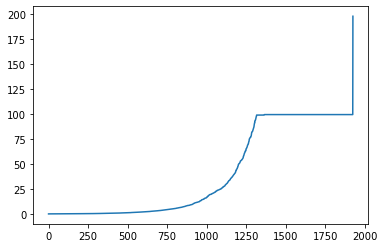

In [145]:
plt.plot(sorted(list(rule_five_df['f_avg_IC50']))) #1926

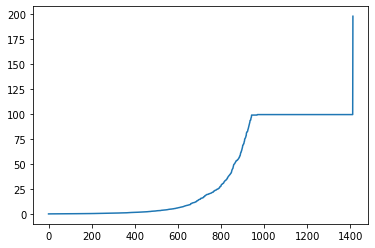

In [147]:
plt.plot(sorted(list(all_five['f_avg_IC50']))) #1413

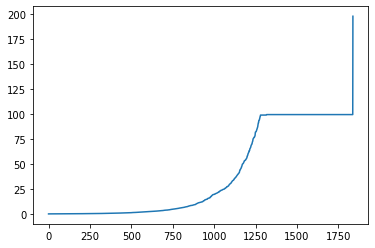

In [148]:
plt.plot(sorted(list(violate_no_more_than_one['f_avg_IC50']))) #1839

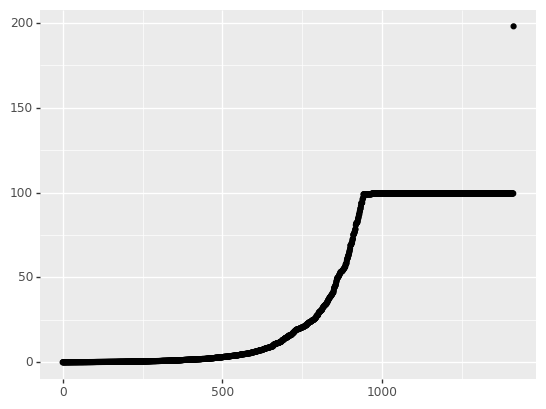

<ggplot: (402961039)>

In [162]:
from plotnine import ggplot, aes, geom_point
(
    ggplot(all_five, aes(x=range(1413), y=sorted(list(all_five['f_avg_IC50'])))) 
    + geom_point()
)

## Similarity (fingerprint)

In [167]:
def comp_Tanimoto(smile1, smile2, rad = 2, bits = 2048):
    mol1 = Chem.MolFromSmiles(smile1)
    mol2 = Chem.MolFromSmiles(smile2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, rad, nBits=bits, useChirality=True)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, rad, nBits=bits, useChirality=True)
    similarity = DataStructs.TanimotoSimilarity(fp1,fp2)
    return similarity

In [175]:
%%time
similarity_dict = {}
for i in range(len(ligand_feature_df)):
    temp_dict = {}
    for j in range(len(ligand_feature_df)):
        temp_dict[ligand_feature_df.loc[j, 'SMILES']] = comp_Tanimoto(ligand_feature_df.loc[i, 'SMILES'], ligand_feature_df.loc[j, 'SMILES'])
    similarity_dict[ligand_feature_df.loc[i, 'SMILES']] = temp_dict

CPU times: user 21min 45s, sys: 3.29 s, total: 21min 48s
Wall time: 21min 51s


In [229]:
with open('/Users/zhujiayuan/Desktop/binding_affinity/tanimoto_similarity.json', 'w') as f:
    json.dump(similarity_dict, f)

## Binding Affinity

#### original scale

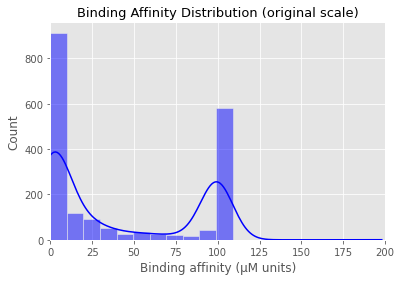

In [223]:
plt.figure(figsize=(6,4))
plt.xlim(0,200)

# training set
fig = sns.histplot(ligand_feature_df['f_avg_IC50'], color = 'b', kde = True, bins = 20) 
# testing set
#fig = sns.histplot(binding_affinity_testing['binding_affinity'], color= 'r', kde = True, bins = 20) 

#plt.legend(labels=['train', 'test'])
plt.title('Binding Affinity Distribution (original scale)', fontsize = 13)
plt.xlabel('Binding affinity (µM units)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

#plt.savefig('../Figure/Binding Affinity Distribution.png', dpi = 300, bbox_inches='tight', facecolor='w')
plt.show()

#### transformed scale (negative base-10 logarithm)

In [224]:
pIC50 = np.array(ligand_feature_df['f_avg_IC50']) * (10**(-6))
pIC50 = -np.log10(pIC50)

In [225]:
print(min(pIC50))
print(max(pIC50))

3.703334809738469
8.573819647563703


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

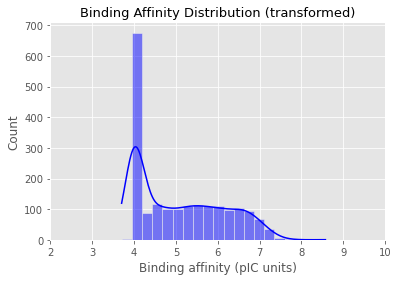

In [227]:
plt.figure(figsize=(6,4))
plt.xlim(2,10)

# training set
fig = sns.histplot(pIC50, color = 'b', kde = True, bins = 20) 
# testing set
#fig = sns.histplot(binding_affinity_testing['binding_affinity'], color= 'r', kde = True, bins = 20) 

#plt.legend(labels=['train', 'test'])
plt.title('Binding Affinity Distribution (transformed)', fontsize = 13)
plt.xlabel('Binding affinity (pIC units)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

#plt.savefig('../Figure/Binding Affinity Distribution.png', dpi = 300, bbox_inches='tight', facecolor='w')
#plt.show()

### Conclusion: Before transformation, there are two clear peaks which are good for classification task. Lower values represent better binding affinity. After negative base-10 logarithm transform, the pIC50 is more smooth, better for regression

### Model Fitting

In [230]:
ligand_feature_df['pIC50'] = pIC50

In [236]:
X_train, X_test, y_train, y_test = train_test_split(ligand_feature_df.iloc[:, 1:209], 
                                                    ligand_feature_df['pIC50'], 
                                                    test_size=0.33, random_state=42)

In [329]:
%%time

# divide into 5-fold
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

pearsonr_benchmark = []
mse_benchmark = []
for train_index, val_index in kf.split(X_train):
    
    X_train_sub = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    y_train_sub = y_train.iloc[train_index].values.ravel()
    y_val = y_train.iloc[val_index].values.ravel()
    
    rf = RandomForestRegressor(n_jobs=6, random_state=42)
    rf.fit(X_train_sub, y_train_sub)
    pred = rf.predict(X_val)
    pearsonr_benchmark.append(stats.pearsonr(y_val, pred)[0])
    mse_benchmark.append(mean_squared_error(y_val, pred))

CPU times: user 21.4 s, sys: 242 ms, total: 21.7 s
Wall time: 4.14 s


In [331]:
pearsonr_benchmark

[0.7227526597212947,
 0.7210374377332397,
 0.7943908051676494,
 0.7052964624388505,
 0.72478635823602]

In [330]:
mse_benchmark

[0.5311150479714968,
 0.49762296428110214,
 0.4146008138401012,
 0.5578227376272833,
 0.5323636802842895]

### consider different number of features

In [245]:
def select_mutual(features, binding_affinity, num_features):
    
    selector = SelectKBest(mutual_info_regression, k = num_features)
    selector.fit(features, binding_affinity)
    
    # Get best features(columns) to keep 
    cols = selector.get_support(indices = True)

    return (cols, selector.scores_)

In [334]:
num_features_list = list(range(20, 208, 20)) + [208]
num_features_list

[20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 208]

In [342]:
%%time

rf_num_features_pearson_dict = {}
rf_num_features_mse_dict = {}

# divide into 5-fold
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)


for num_features in num_features_list:
    pearsonr = []
    mse = []
    for train_index, val_index in kf.split(X_train):
    
        X_train_sub = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_train_sub = y_train.iloc[train_index].values.ravel()
        y_val = y_train.iloc[val_index].values.ravel()
        
        feature_index = select_mutual(X_train_sub, y_train_sub, num_features)[0]
        X_train_sub = X_train_sub.iloc[:, feature_index]
        X_val = X_val.iloc[:, feature_index]

        rf = RandomForestRegressor(n_jobs=6, random_state=42)
        rf.fit(X_train_sub, y_train_sub)
        pred = rf.predict(X_val)
        
        pearsonr.append(stats.pearsonr(y_val, pred)[0])
        mse.append(mean_squared_error(y_val, pred))
        
    rf_num_features_pearson_dict[num_features] = np.mean(pearsonr)
    rf_num_features_mse_dict[num_features] = np.mean(mse)

CPU times: user 3min 46s, sys: 2.39 s, total: 3min 49s
Wall time: 1min 25s


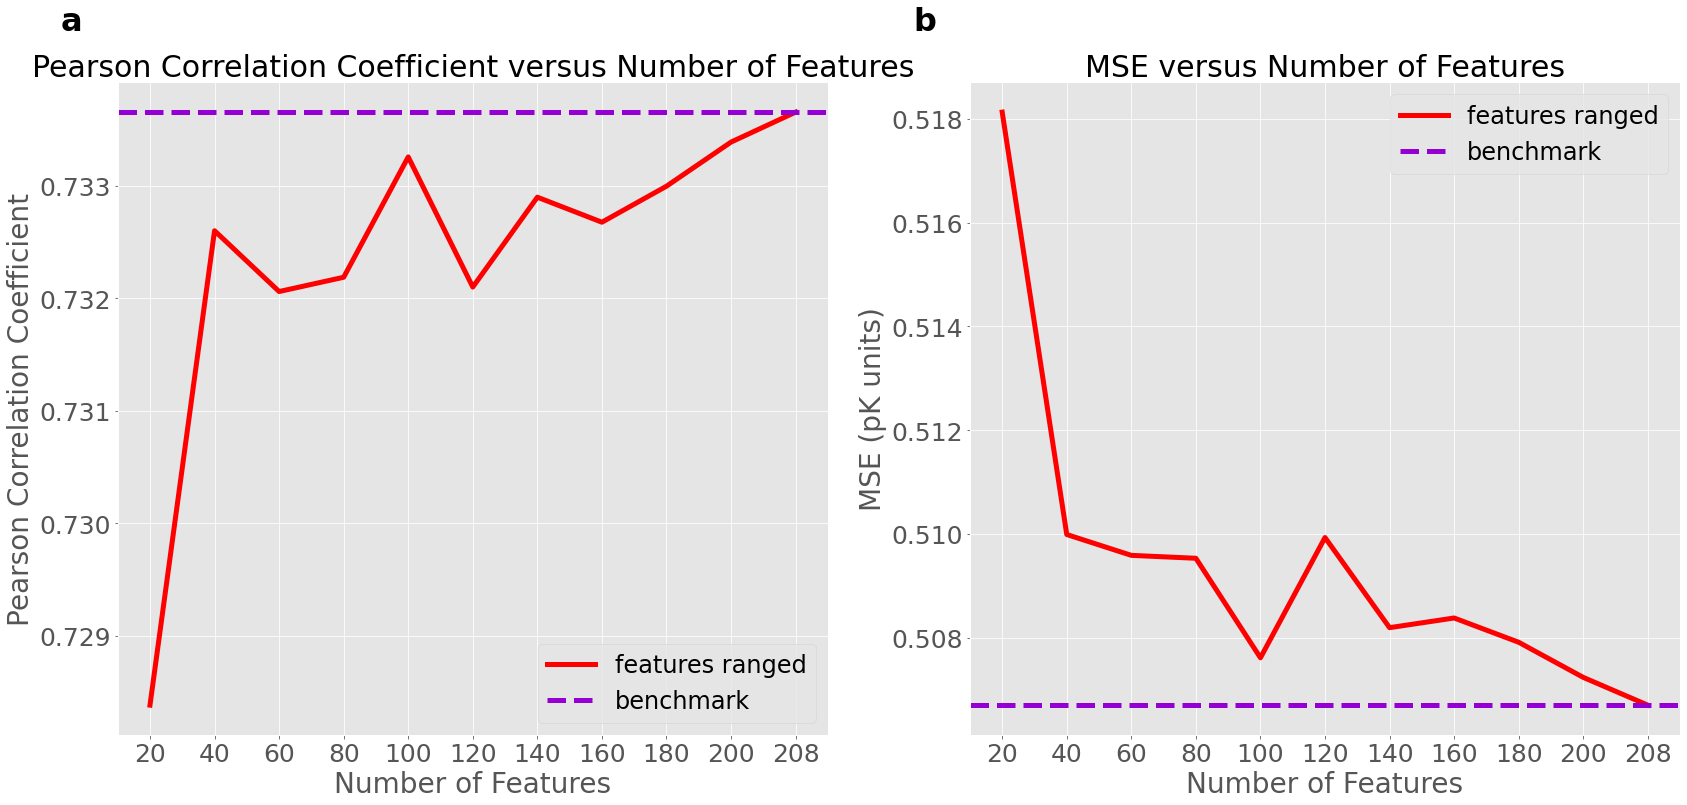

In [343]:
#plt.figure(figsize=(28,12))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(28,12))

# plot for Pearson correlation coefficient
plt.subplot(1,2,1)
# select best k features
plt.plot(range(11), rf_num_features_pearson_dict.values(), color = 'red', linewidth=5, label = 'features ranged')
# benchmark
plt.axhline(y = np.mean(pearsonr_benchmark), color='darkviolet', linestyle='--', linewidth=5, 
            label = 'benchmark')


plt.legend(fontsize=24)
plt.xticks(range(11), num_features_list)
plt.title(f'Pearson Correlation Coefficient versus Number of Features', fontsize = 30)
plt.xlabel(f'Number of Features', fontsize = 28)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

# plot for MSE
plt.subplot(1,2,2)
# select best k features
plt.plot(range(11), rf_num_features_mse_dict.values(), color = 'red', linewidth=5, label = 'features ranged')
# benchmark
plt.axhline(y = np.mean(mse_benchmark), color='darkviolet', linestyle='--', linewidth=5, 
            label = 'benchmark')

plt.legend(fontsize=24)
plt.xticks(range(11), num_features_list)
plt.title(f'MSE versus Number of Features', fontsize = 30)
plt.xlabel(f'Number of Features', fontsize = 28)
plt.ylabel('MSE (pK units)', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)


for ax, annotation in zip((ax1,ax2), ['a', 'b']):
    ax.text(-0.08, 1.08, annotation, transform=ax.transAxes, size=32, weight='bold')
    
# save figure
#plt.savefig('../Figure/Problem1.png', dpi = 300, bbox_inches='tight', facecolor='w')
#plt.show()

#### Conclusion: select 100 features

### consider different number of estimators

In [344]:
%%time

num_features = 100

rf_estimator_pearson_dict = {}
rf_estimator_mse_dict = {}

# divide into 5-fold
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
for element in range(100, 2001, 300): 
    
    pearsonr = []
    mse = []
    for train_index, val_index in kf.split(X_train):
        
        X_train_sub = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_train_sub = y_train.iloc[train_index].values.ravel()
        y_val = y_train.iloc[val_index].values.ravel()
        
        feature_index = select_mutual(X_train_sub, y_train_sub, num_features)[0]
        X_train_sub = X_train_sub.iloc[:, feature_index]
        X_val = X_val.iloc[:, feature_index]

        rf = RandomForestRegressor(n_estimators=element, n_jobs=6, random_state=42)
        rf.fit(X_train_sub, y_train_sub)
        pred = rf.predict(X_val)
        
        pearsonr.append(stats.pearsonr(y_val, pred)[0])
        mse.append(mean_squared_error(y_val, pred))
        
    rf_estimator_pearson_dict[element] = np.mean(pearsonr)
    rf_estimator_mse_dict[element] = np.mean(mse)

CPU times: user 20min 14s, sys: 13.4 s, total: 20min 27s
Wall time: 4min 15s


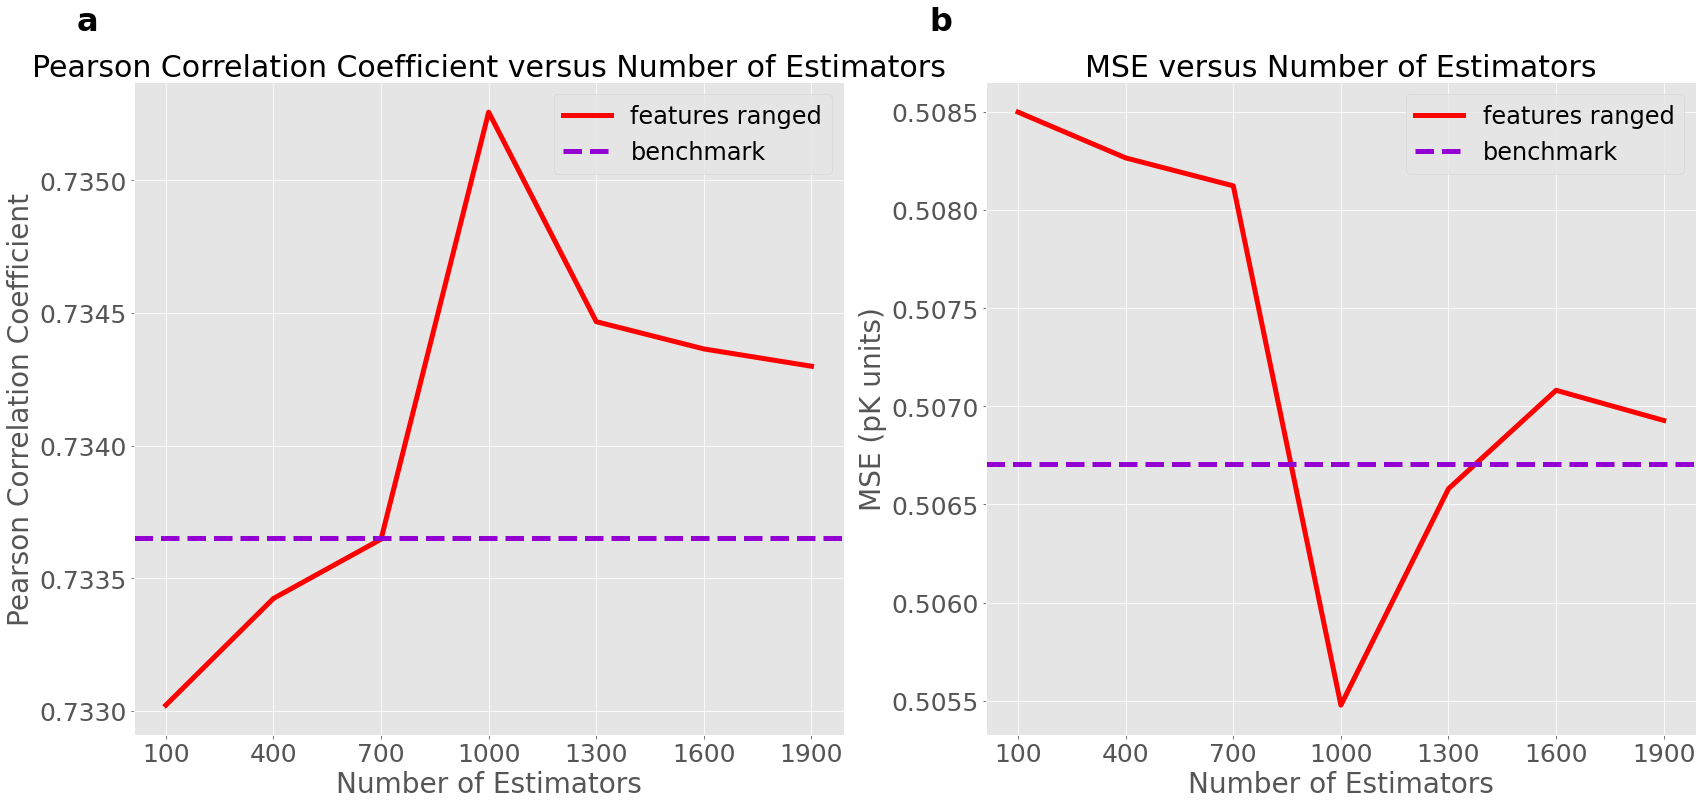

In [345]:
#plt.figure(figsize=(28,12))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(28,12))

# plot for Pearson correlation coefficient
plt.subplot(1,2,1)
# select number of estimator
plt.plot(range(7), rf_estimator_pearson_dict.values(), color = 'red', linewidth=5, label = 'estimators ranged')
# benchmark
plt.axhline(y = np.mean(pearsonr_benchmark), color='darkviolet', linestyle='--', linewidth=5, 
            label = 'benchmark')


plt.legend(fontsize=24)
plt.xticks(range(7), list(range(100, 2001, 300)))
plt.title(f'Pearson Correlation Coefficient versus Number of Estimators', fontsize = 30)
plt.xlabel(f'Number of Estimators', fontsize = 28)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

# plot for MSE
plt.subplot(1,2,2)
# select number of estimator
plt.plot(range(7), rf_estimator_mse_dict.values(), color = 'red', linewidth=5, label = 'estimators ranged')
# benchmark
plt.axhline(y = np.mean(mse_benchmark), color='darkviolet', linestyle='--', linewidth=5, 
            label = 'benchmark')

plt.legend(fontsize=24)
plt.xticks(range(7), list(range(100, 2001, 300)))
plt.title(f'MSE versus Number of Estimators', fontsize = 30)
plt.xlabel(f'Number of Estimators', fontsize = 28)
plt.ylabel('MSE (pK units)', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)


for ax, annotation in zip((ax1,ax2), ['a', 'b']):
    ax.text(-0.08, 1.08, annotation, transform=ax.transAxes, size=32, weight='bold')
    
# save figure
#plt.savefig('../Figure/Problem1.png', dpi = 300, bbox_inches='tight', facecolor='w')
#plt.show()

#### Conclusion: select 1000 estimators

### consider different number of max features

In [347]:
%%time

num_features = 100
n_estimators = 1000

rf_max_features_pearson_dict = {}
rf_max_features_mse_dict = {}

# divide into 5-fold
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
for element in np.arange(0.2, 0.51, 0.05): 
    
    pearsonr = []
    mse = []
    for train_index, val_index in kf.split(X_train):
        
        X_train_sub = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_train_sub = y_train.iloc[train_index].values.ravel()
        y_val = y_train.iloc[val_index].values.ravel()
        
        feature_index = select_mutual(X_train_sub, y_train_sub, num_features)[0]
        X_train_sub = X_train_sub.iloc[:, feature_index]
        X_val = X_val.iloc[:, feature_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, max_features = element, 
                                   n_jobs=6, random_state=42)
        rf.fit(X_train_sub, y_train_sub)
        pred = rf.predict(X_val)
        
        pearsonr.append(stats.pearsonr(y_val, pred)[0])
        mse.append(mean_squared_error(y_val, pred))
        
    rf_max_features_pearson_dict[element] = np.mean(pearsonr)
    rf_max_features_mse_dict[element] = np.mean(mse)

CPU times: user 7min 37s, sys: 10.4 s, total: 7min 47s
Wall time: 2min 4s


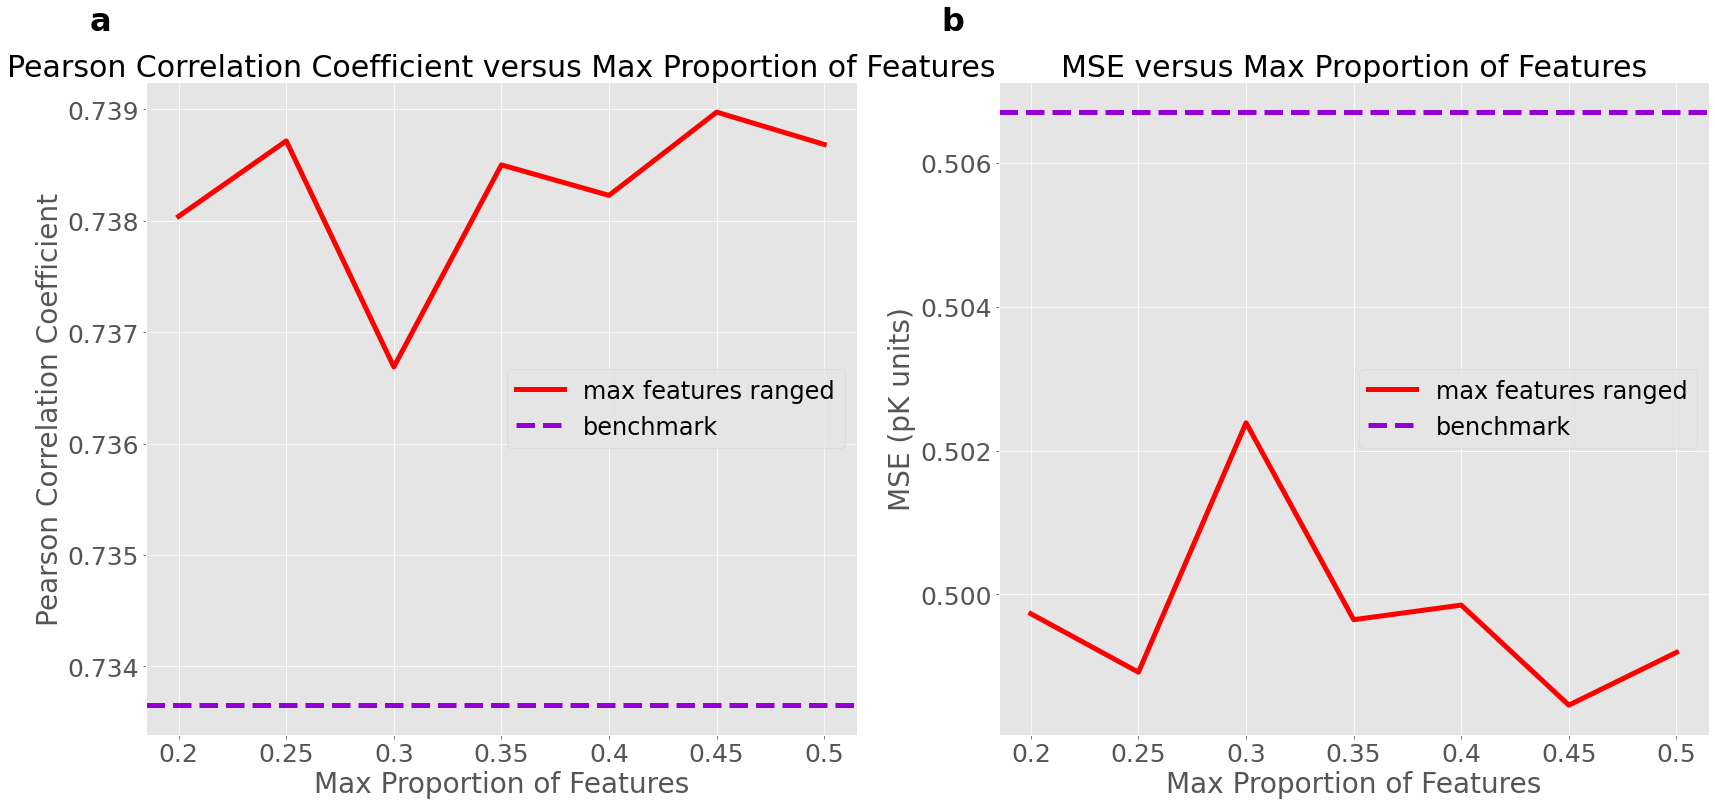

In [431]:
#plt.figure(figsize=(28,12))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(28,12))

# plot for Pearson correlation coefficient
plt.subplot(1,2,1)
# select number of max features
plt.plot(range(7), rf_max_features_pearson_dict.values(), color = 'red', linewidth=5, label = 'max features ranged')
# benchmark
plt.axhline(y = np.mean(pearsonr_benchmark), color='darkviolet', linestyle='--', linewidth=5, 
            label = 'benchmark')


plt.legend(fontsize=24)
plt.xticks(range(7), np.arange(0.2, 0.51, 0.05).round(2))
plt.title(f'Pearson Correlation Coefficient versus Max Proportion of Features', fontsize = 30)
plt.xlabel(f'Max Proportion of Features', fontsize = 28)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

# plot for MSE
plt.subplot(1,2,2)
# select number of max features
plt.plot(range(7), rf_max_features_mse_dict.values(), color = 'red', linewidth=5, label = 'max features ranged')
# benchmark
plt.axhline(y = np.mean(mse_benchmark), color='darkviolet', linestyle='--', linewidth=5, 
            label = 'benchmark')

plt.legend(fontsize=24)
plt.xticks(range(7), np.arange(0.2, 0.51, 0.05).round(2))
plt.title(f'MSE versus Max Proportion of Features', fontsize = 30)
plt.xlabel(f'Max Proportion of Features', fontsize = 28)
plt.ylabel('MSE (pK units)', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)


for ax, annotation in zip((ax1,ax2), ['a', 'b']):
    ax.text(-0.08, 1.08, annotation, transform=ax.transAxes, size=32, weight='bold')
    
# save figure
#plt.savefig('../Figure/Problem1.png', dpi = 300, bbox_inches='tight', facecolor='w')
#plt.show()

#### Conclusion: select 0.45 as max features

### Compare similarity

In [349]:
similarity_range = list(np.arange(0.3, 1.01, 0.1).round(2))
similarity_range.append('all')
similarity_range


[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 'all']

In [426]:
%%time

# top 150 features
num_features = 150
n_estimators = 1000
max_features = 0.45

rf_pearson_similarity = {}
rf_mse_similarity = {}
rf_training_counts = {}

# validate on ligand's similarity level
for similarity_value in similarity_range:
    
    train_temp = ligand_feature_df.loc[X_train.index]
    train_temp = train_temp.set_index('SMILES')
    
    if similarity_value == 'all':
        training_pose = list(train_temp.index)
    else:
        too_similar = set()
        for test_sample in ligand_feature_df.loc[X_test.index]['SMILES']:
            for key, value in similarity_dict[test_sample].items():
                if value >= similarity_value:
                    too_similar.add(key)
                    
        training_pose = list(set(train_temp.index).difference(too_similar))

        
    X_train_sub = train_temp.loc[training_pose]
    X_train_sub = X_train_sub.iloc[:, :208]
    y_train_sub = X_train_temp.loc[training_pose]
    y_train_sub = y_train_sub.iloc[:, 209]
    X_test_sub = X_test.copy()

    # select k best features with training set
    features_index = select_mutual(X_train_sub, y_train_sub, num_features)[0]
    X_train_sub = X_train_sub.iloc[:, np.array(features_index)]
    X_test_sub = X_test_sub.iloc[:, np.array(features_index)]

    # fit the model
    rf = RandomForestRegressor(n_estimators=n_estimators, max_features = max_features, 
                                   n_jobs=6, random_state=42)
    rf.fit(X_train_sub, y_train_sub)
    pred = rf.predict(X_test_sub)

    rf_pearson_similarity[similarity_value] = stats.pearsonr(y_test, pred)[0]
    rf_mse_similarity[similarity_value] = mean_squared_error(y_test, pred)
    rf_training_counts[similarity_value] = len(training_pose)

CPU times: user 1min 57s, sys: 2.02 s, total: 1min 59s
Wall time: 29.3 s


In [427]:
rf_pearson_similarity

{0.3: -0.040533972261061035,
 0.4: 0.24401505312905816,
 0.5: 0.516553463210948,
 0.6: 0.6707343656762641,
 0.7: 0.7435994334619225,
 0.8: 0.7898281913383458,
 0.9: 0.7647658554063005,
 1.0: 0.7656399365971412,
 'all': 0.7666155387355233}

In [428]:
rf_mse_similarity

{0.3: 1.8444648941326196,
 0.4: 1.4797829237091602,
 0.5: 1.0963486908677609,
 0.6: 0.7003773969182981,
 0.7: 0.5118030309814451,
 0.8: 0.4208717114951057,
 0.9: 0.46244494668161024,
 1.0: 0.4619634777019923,
 'all': 0.4605333439166033}

In [429]:
rf_training_counts # no sample is identical (similarity 1.0) to it

{0.3: 85,
 0.4: 151,
 0.5: 214,
 0.6: 343,
 0.7: 626,
 0.8: 998,
 0.9: 1269,
 1.0: 1290,
 'all': 1290}

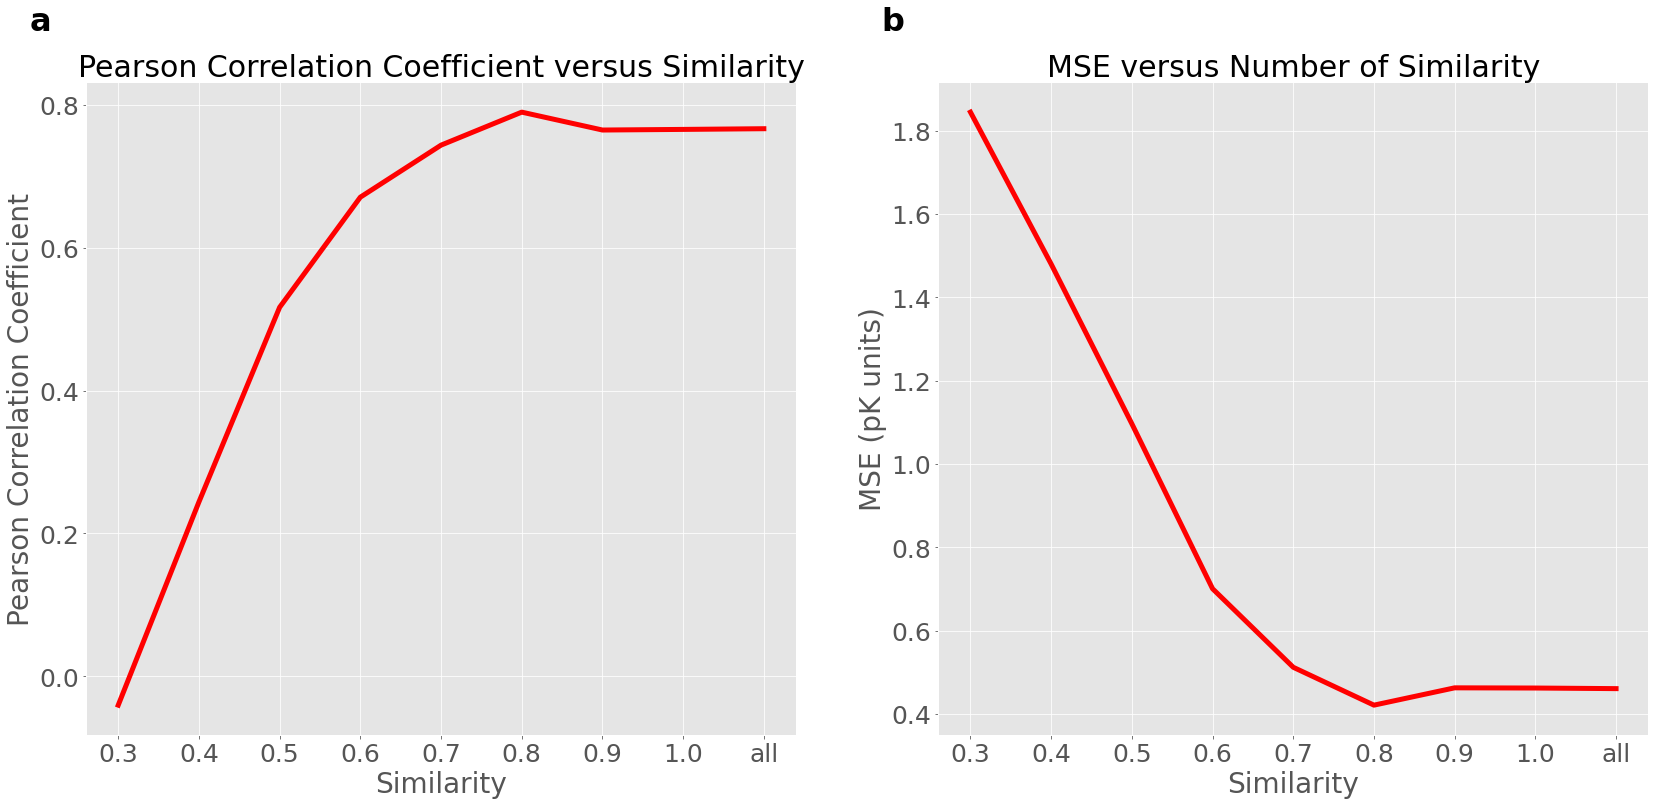

In [433]:
#plt.figure(figsize=(28,12))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(28,12))

# plot for Pearson correlation coefficient
plt.subplot(1,2,1)
# similarity
plt.plot(range(9), rf_pearson_similarity.values(), color = 'red', linewidth=5)

plt.xticks(range(9), similarity_range)
plt.title(f'Pearson Correlation Coefficient versus Similarity', fontsize = 30)
plt.xlabel(f'Similarity', fontsize = 28)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

# plot for MSE
plt.subplot(1,2,2)
# select best k features
plt.plot(range(9), rf_mse_similarity.values(), color = 'red', linewidth=5)

plt.xticks(range(9), similarity_range)
plt.title(f'MSE versus Number of Similarity', fontsize = 30)
plt.xlabel(f'Similarity', fontsize = 28)
plt.ylabel('MSE (pK units)', fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)


for ax, annotation in zip((ax1,ax2), ['a', 'b']):
    ax.text(-0.08, 1.08, annotation, transform=ax.transAxes, size=32, weight='bold')
    
# save figure
#plt.savefig('../Figure/Problem1.png', dpi = 300, bbox_inches='tight', facecolor='w')
#plt.show()

### Final model

In [434]:
# fit the model
rf = RandomForestRegressor(n_estimators=n_estimators, max_features = max_features, 
                                   n_jobs=6, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [437]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

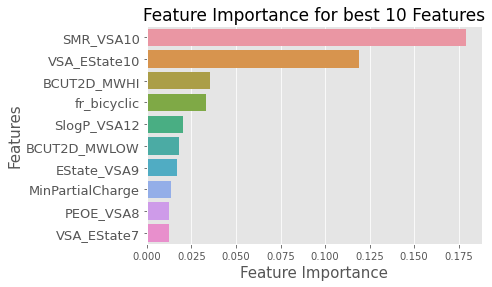

In [448]:
feature_importance_df = pd.DataFrame(rf.feature_importances_, 
                                     X_train.columns,
                                    columns = ['feature importance'])
feature_importance_df.sort_values(by=['feature importance'], inplace=True, ascending = False)
top_feature_importance_df = feature_importance_df.iloc[:10, ]


# plot
plt.figure(figsize = [6, 4])
fig = sns.barplot(x = 'feature importance', y = top_feature_importance_df.index, 
                  data = top_feature_importance_df)

fig.set_title('Feature Importance for best 10 Features', fontsize = 17, loc = 'center')
fig.set_xlabel('Feature Importance', fontsize = 15)
fig.set_ylabel('Features', fontsize = 15)
fig.set_yticklabels(fig.get_yticklabels(), fontsize = 13)


# save figure
#plt.savefig('../Figure/Feature Importance for best 10 Features.png', dpi = 300,
            #bbox_inches='tight', facecolor='w')
plt.show()

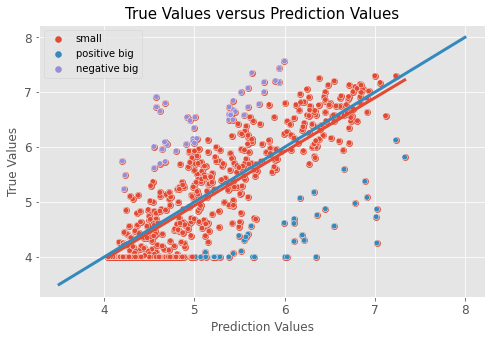

In [480]:
plt.figure(figsize=(8, 5))


diff_df=pd.DataFrame({'prediction value':pred, 'true value': y_test})
diff_btw = []
for i in diff_df.index:
    if abs(diff_df.loc[i, 'prediction value'] - diff_df.loc[i, 'true value']) > 1:
        if diff_df.loc[i, 'prediction value'] - diff_df.loc[i, 'true value'] > 0:
            diff_btw.append('positive big')
        else:
            diff_btw.append('negative big')
    else:
        diff_btw.append('small')
diff_df['labels'] = diff_btw 

# plot
sns.regplot(x='prediction value', y='true value', data=diff_df, ci = 0,line_kws={'linewidth':3})
sns.scatterplot(data=diff_df, x='prediction value', y='true value', hue = 'labels', s = 30)
plt.plot([3.5, 8], [3.5, 8], linewidth=3)
plt.legend(prop={'size': 10})
plt.title('True Values versus Prediction Values', fontsize = 15)
plt.xlabel('Prediction Values', fontsize = 12)
plt.ylabel('True Values', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)



# save figure
#plt.savefig('../Figure/Prediction versus True Plot.png', dpi = 300, bbox_inches='tight', facecolor='w')
plt.show()

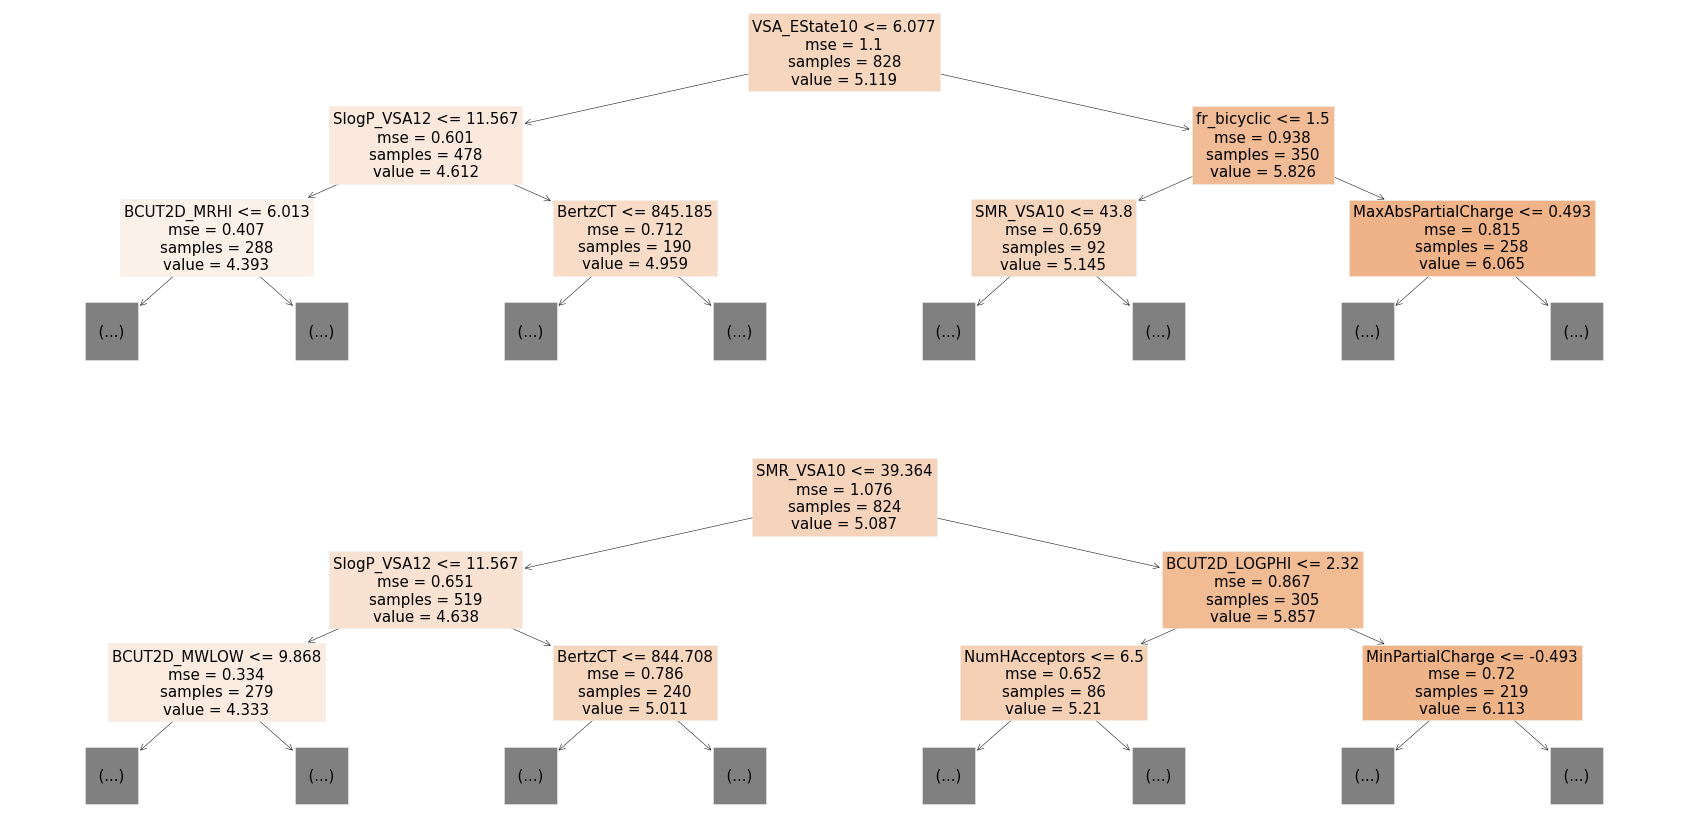

In [483]:
plt.figure(figsize=(30, 15))

# first example tree
plt.subplot(2,1,1)
fig = plot_tree(rf[1], feature_names = list(X_train), 
          max_depth = 2, filled = True, fontsize = 15)

# second example tree
plt.subplot(2,1,2)
plot_tree(rf[2], feature_names = list(X_train), 
          max_depth = 2, filled = True, fontsize = 15)

# save figure
#plt.savefig('../Figure/Tree Plot.png', dpi = 300, bbox_inches='tight', facecolor='w')
plt.show()

## PCA

In [496]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(ligand_feature_df.iloc[:, 1:209])
pca.explained_variance_ratio_

array([1.0000000e+00, 2.2056126e-25])

In [499]:
V=pd.DataFrame(data = pca.components_.T, index = X_train.columns)

In [500]:
V[0].sort_values(ascending = False).head(5).values

array([1.00000000e+00, 6.48594719e-14, 2.64116241e-14, 2.63898955e-14,
       2.45640754e-14])

In [501]:
V[0].sort_values(ascending = False).head(5).index

Index(['Ipc', 'BertzCT', 'MolWt', 'ExactMolWt', 'HeavyAtomMolWt'], dtype='object')